In [1]:
#I like my cells wide and proud
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Review the resources landscape:
```
!nvidia-smi
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import xrange
import logging
import os
###########################
from cleverhans.attacks import CarliniWagnerL2, SaliencyMapMethod, FastGradientMethod, DeepFool, MadryEtAl
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
from cleverhans.utils import set_log_level
from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_train, model_eval, tf_model_load
from cleverhans_tutorials.tutorial_models import make_basic_cnn
########### keras ############
# from cleverhans.utils_keras import cnn_model as cnn_keras
# from cleverhans.utils_keras import KerasModelWrapper

/Users/nishant/Projects/unifyid/Lyapunov_defense/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


```
def make_basic_cnn(nb_filters=64, nb_classes=10,
                   input_shape=(None, 28, 28, 1)):
    layers = [Conv2D(nb_filters, (8, 8), (2, 2), "SAME"),
              ReLU(),
              Conv2D(nb_filters * 2, (6, 6), (2, 2), "VALID"),
              ReLU(),
              Conv2D(nb_filters * 2, (5, 5), (1, 1), "VALID"),
              ReLU(),
              Flatten(),
              Linear(nb_classes),
              Softmax()]

    model = MLP(layers, input_shape)
    return model
```

In [3]:
import tensorflow as tf
print(tf.__version__)
import cleverhans
cleverhans.__version__

1.4.0


'2.0.0-282675e7a58ad510a0ef523f64c946dd'

# Initialize the parameters as per:
https://github.com/tensorflow/cleverhans/blob/b8d15f3d7b6f820f812087512b60d9675cb431eb/cleverhans_tutorials/mnist_tutorial_cw.py

In [4]:
#     :param train_start: index of first training set example
#     :param train_end: index of last training set example
#     :param test_start: index of first test set example
#     :param test_end: index of last test set example
#     :param viz_enabled: (boolean) activate plots of adversarial examples
#     :param nb_epochs: number of epochs to train model
#     :param batch_size: size of training batches
#     :param nb_classes: number of output classes
#     :param source_samples: number of test inputs to attack
#     :param learning_rate: learning rate for training
#     :param model_path: path to the model file
#     :param targeted: should we run a targeted attack? or untargeted?
train_start=0
train_end=60000
test_start=0
test_end=10000
viz_enabled=True
nb_epochs=6
batch_size=128
nb_classes=10
source_samples=10
learning_rate=0.001
attack_iterations=100
model_path=os.path.join("models_tf2keras", "mnist")
targeted=True
# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Model definition:

In [5]:
# MNIST-specific dimensions
img_rows = 28
img_cols = 28
channels = 1

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

# # Create TF session
# tf.device("/gpu:0")
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=.333), 
                                                 device_count={'CPU':2, 'GPU':1}))
print("Created TensorFlow session.")
set_log_level(logging.DEBUG)

# Get MNIST test data
X_train, Y_train, X_test, Y_test = data_mnist(train_start=train_start,
                                              train_end=train_end,
                                              test_start=test_start,
                                              test_end=test_end)

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols, channels))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

# Define TF model graph
model = make_basic_cnn()
preds = model(x)
print("Defined TensorFlow model graph.")


Created TensorFlow session.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)
Defined TensorFlow model graph.


###########################################################################
# Training the model using TensorFlow
###########################################################################

In [6]:
# Train an MNIST model
train_params = {
    'nb_epochs': nb_epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'train_dir': os.path.join(*os.path.split(model_path)[:-1]),
    'filename': os.path.split(model_path)[-1]
}

rng = np.random.RandomState([2017, 8, 30])
# check if we've trained before, and if we have, use that pre-trained model
# if os.path.exists(model_path + ".meta"):
#     tf_model_load(sess, model_path)
# else:
model_train(sess, x, y, preds, X_train, Y_train, args=train_params,
                save=os.path.exists("models_tf2keras"), rng=rng)

# Evaluate the accuracy of the MNIST model on legitimate test examples
eval_params = {'batch_size': batch_size}
accuracy = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
assert X_test.shape[0] == test_end - test_start, X_test.shape
print('Test accuracy on legitimate test examples: {0}'.format(accuracy))
report.clean_train_clean_eval = accuracy

[INFO 2017-11-18 23:44:42,113 cleverhans] Epoch 0 took 61.47657489776611 seconds
[INFO 2017-11-18 23:45:39,232 cleverhans] Epoch 1 took 57.1111421585083 seconds
[INFO 2017-11-18 23:46:36,123 cleverhans] Epoch 2 took 56.88378691673279 seconds
[INFO 2017-11-18 23:47:33,009 cleverhans] Epoch 3 took 56.87916707992554 seconds
[INFO 2017-11-18 23:48:32,735 cleverhans] Epoch 4 took 59.718019008636475 seconds
[INFO 2017-11-18 23:49:33,018 cleverhans] Epoch 5 took 60.275835037231445 seconds
[INFO 2017-11-18 23:49:33,019 cleverhans] Completed model training.


Test accuracy on legitimate test examples: 0.99


# Let's pick 10 legit examples to target:

Crafting 10 * 9 adversarial examples


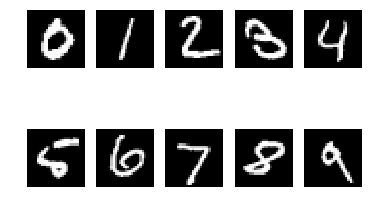

In [7]:
nb_adv_per_sample = str(nb_classes - 1)
print('Crafting ' + str(source_samples) + ' * ' + nb_adv_per_sample + ' adversarial examples')
###########################################################################

assert source_samples == nb_classes
idxs = [np.where(np.argmax(Y_test, axis=1) == i)[0][0] for i in range(nb_classes)]
# [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
# Pick the first appearances of the 9 numbers in X_test
for i,idx in enumerate(idxs):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx,:,:,0],cmap='gray')
    plt.axis('off')


# Create adv samples using the Carlini-L2 attack:

In [8]:
# Form a 10 x 10 array of the inputs that you seek to target:
adv_inputs = np.array([[instance] * nb_classes for instance in X_test[idxs]],dtype=np.float32)
adv_inputs = adv_inputs.reshape((source_samples * nb_classes, img_rows, img_cols, 1))


one_hot = np.zeros((nb_classes, nb_classes))
one_hot[np.arange(nb_classes), np.arange(nb_classes)] = 1



adv_ys = np.array([one_hot] * source_samples,dtype=np.float32).reshape((source_samples * nb_classes, nb_classes))
# yname = "y_target"
# Instantiate a CW attack object
cw = CarliniWagnerL2(model, back='tf', sess=sess)

def get_cw_params():
    cw_params = {'binary_search_steps': 1,
                 'max_iterations': attack_iterations,
                 'learning_rate': 0.1,
                 'batch_size': source_samples * nb_classes if
                 targeted else source_samples,
                 'initial_const': 10}
    if targeted:
        cw_params['y_target'] = adv_ys
    return cw_params
cw_params = get_cw_params()

adv = cw.generate_np(adv_inputs, **cw_params)

[INFO 2017-11-18 23:49:36,694 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2017-11-18 23:49:37,604 cleverhans] Running CWL2 attack on instance 0 of 100
[DEBUG 2017-11-18 23:49:37,616 cleverhans]   Binary search step 0 of 1
[DEBUG 2017-11-18 23:49:37,798 cleverhans]     Iteration 0 of 100: loss=1.8e+04 l2=0 f=-2.57
[DEBUG 2017-11-18 23:49:39,105 cleverhans]     Iteration 10 of 100: loss=8.47e+03 l2=7.22 f=-2.07
[DEBUG 2017-11-18 23:49:40,227 cleverhans]     Iteration 20 of 100: loss=3.11e+03 l2=18.1 f=-1.72
[DEBUG 2017-11-18 23:49:41,249 cleverhans]     Iteration 30 of 100: loss=2.42e+03 l2=22.6 f=-1.69
[DEBUG 2017-11-18 23:49:42,331 cleverhans]     Iteration 40 of 100: loss=2.07e+03 l2=20.2 f=-1.76
[DEBUG 2017-11-18 23:49:43,585 cleverhans]     Iteration 50 of 100: loss=1.73e+03 l2=17 f=-1.82
[DEBUG 2017-11-18 23:49:44,637 cleverhans]     Iteration 60 of 100: loss=1.53e+03 l2=15.3 f=-1.85
[DEBUG 2017-11-18 23:49:45,698 cleverhans]     Iteration 70 of 100: loss=1

# Now, how good were these adv examples?

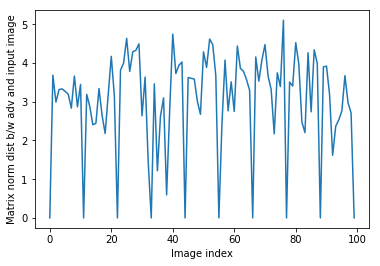

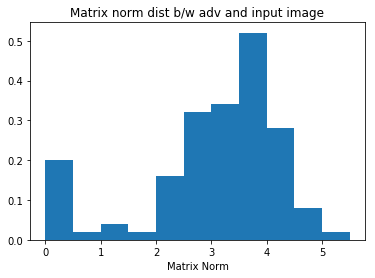

In [9]:
dev=np.zeros(100)
for i in range(100):
    dev[i]=np.linalg.norm(np.abs(adv[i,:,:,0]-adv_inputs[i,:,:,0]))
plt.plot(dev)
plt.xlabel('Image index')
plt.ylabel('Matrix norm dist b/w adv and input image')
plt.savefig('figs/mnist_normdist.eps')

plt.figure()
plt.xlabel('Matrix Norm')
plt.title('Matrix norm dist b/w adv and input image')
plt.hist(dev, bins=np.arange(0, 6, 0.5), normed=True)
plt.show()
plt.savefig('figs/mnist_normdist_hist.eps')

In [10]:
adv.shape

(100, 28, 28, 1)

In [11]:
eval_params = {'batch_size': np.minimum(nb_classes, source_samples)}
adv_accuracy = model_eval(sess, x, y, preds, adv, adv_ys, args=eval_params)

# Initialize our array for grid visualization
grid_shape = (nb_classes, nb_classes, img_rows, img_cols, channels)
grid_viz_data = np.zeros(grid_shape, dtype='f')

for j in range(nb_classes):
    for i in range(nb_classes):
        grid_viz_data[i, j] = adv[i * nb_classes + j]


print(grid_viz_data.shape)

print('--------------------------------------')

# Compute the number of adversarial examples that were successfully found
print('Avg. rate of successful adv. examples {0:.4f}'.format(adv_accuracy))
report.clean_train_adv_eval = 1. - adv_accuracy

# Compute the average distortion introduced by the algorithm
percent_perturbed = np.mean(np.sum((adv - adv_inputs)**2,
                                   axis=(1, 2, 3))**.5)
print('Avg. L_2 norm of perturbations {0:.4f}'.format(percent_perturbed))

# Close TF session
# sess.close()

(10, 10, 28, 28, 1)
--------------------------------------
Avg. rate of successful adv. examples 1.0000
Avg. L_2 norm of perturbations 3.0407


In [12]:
report.__dict__

{'adv_train_adv_eval': 0.0,
 'adv_train_clean_eval': 0.0,
 'clean_train_adv_eval': 0.0,
 'clean_train_clean_eval': 0.98999999999999999,
 'train_adv_train_adv_eval': 0.0,
 'train_adv_train_clean_eval': 0.0,
 'train_clean_train_adv_eval': 0.0,
 'train_clean_train_clean_eval': 0.0}

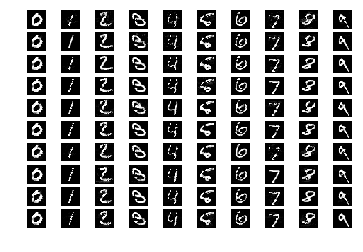

In [13]:
# Finally, block & display a grid of all the adversarial examples
fig = grid_visual(grid_viz_data)
# plt.savefig('mnist_grid.eps')

In [14]:
fig.savefig('figs/mnist_cw_grid.eps')

In [15]:
# A nifty little function to visualize matrices
def plot_mat(intersection_matrix,fig_size=(15,15)):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.matshow(intersection_matrix, cmap=plt.cm.Blues)
    for i in xrange(intersection_matrix.shape[1]):
        for j in xrange(intersection_matrix.shape[0]):
            c = round(intersection_matrix[j,i],2)
            ax.text(i, j, str(c), va='center', ha='center')

# Here begins the Lyapunov exponent based defense:

In [16]:
from nolds import lyap_e

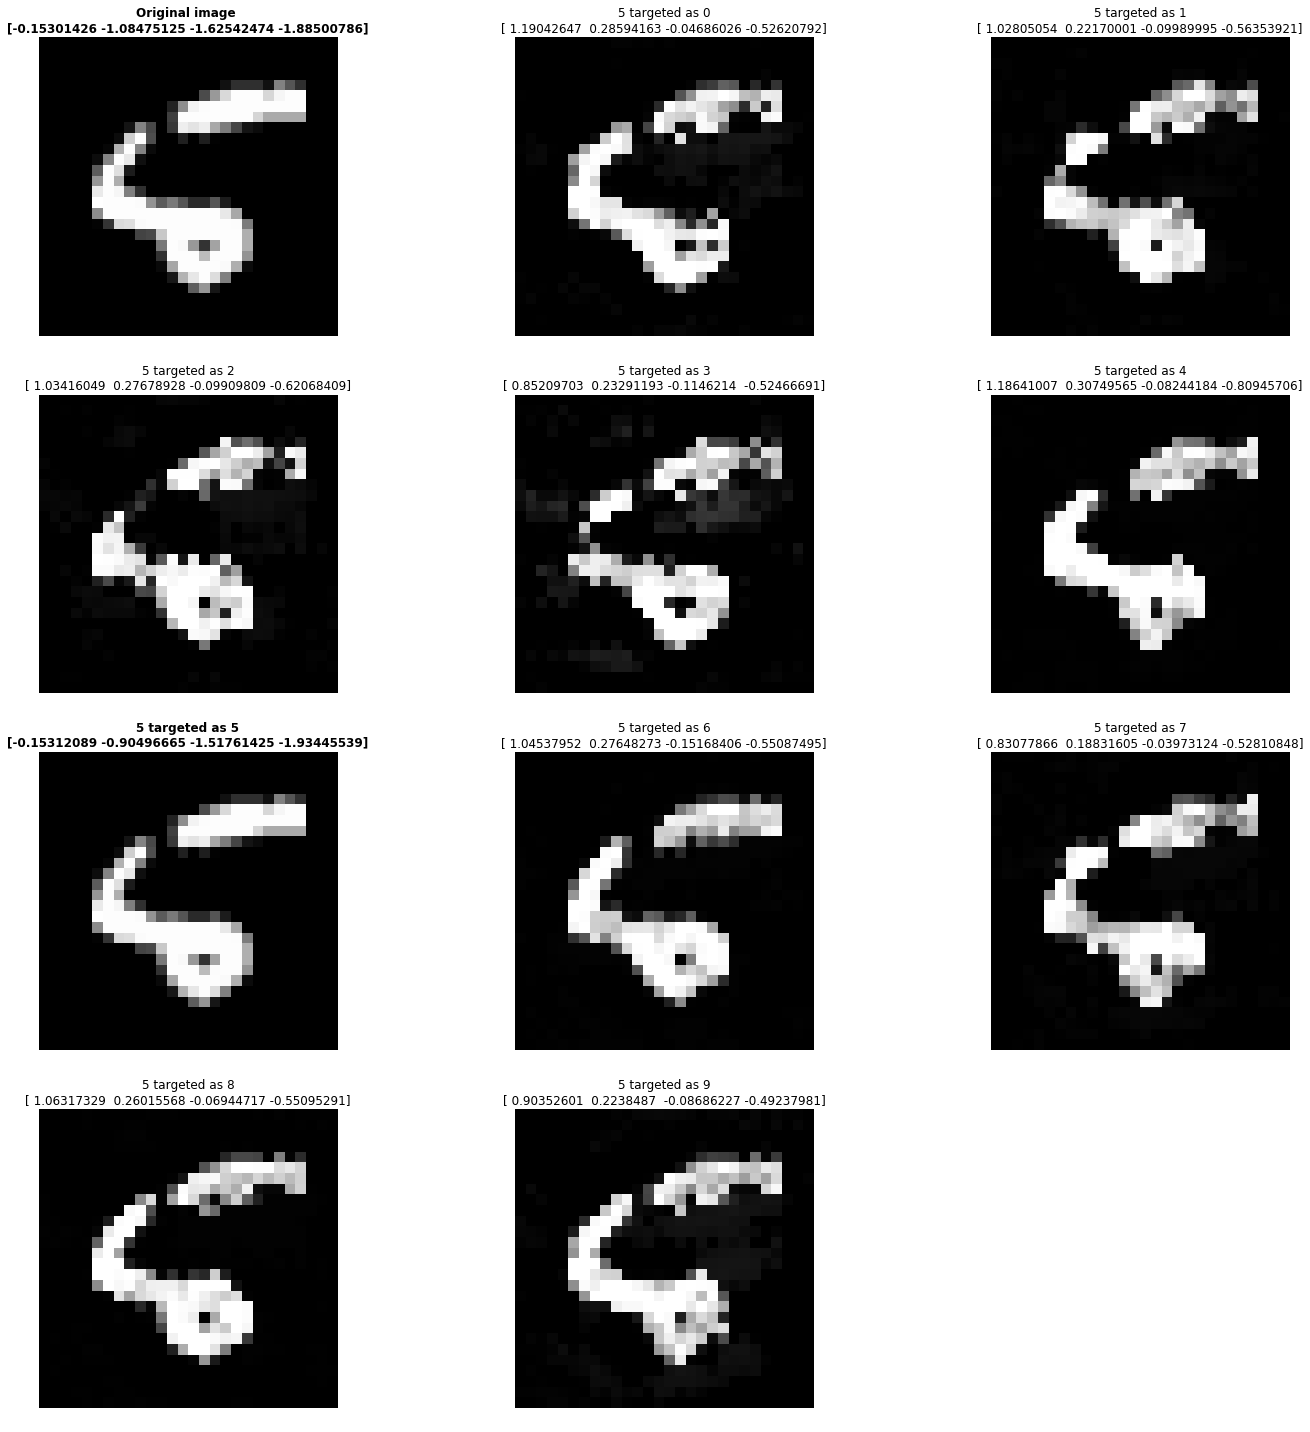

In [17]:
plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
plt.imshow(X_test[idxs[5],:,:,0],cmap='gray');
plt.axis('off');
plt.title('Original image \n'+str(lyap_e(X_test[idxs[5],:,:,0].flatten())),fontweight='bold')


for i in range(10):
    plt.subplot(4,3,i+2)
    plt.imshow(grid_viz_data[5,i,:,:,0],cmap='gray')
    if(i==5):
        plt.title('5 targeted as '+str(i)+'\n'+str(lyap_e(grid_viz_data[5,i,:,:,0].flatten())),fontweight='bold')
         
         
    else:
        plt.title('5 targeted as '+str(i)+'\n'+str(lyap_e(grid_viz_data[5,i,:,:,0].flatten())))
    plt.axis('off')

plt.tight_layout()
plt.savefig('figs/ex_5_mnist.eps')

In [18]:
from tqdm import tqdm

### Generate the lyapunov matrix for the MNIST dataset so that we can publically share this:
```
n_test=X_test.shape[0]
lya_e_test_mat=np.zeros((n_test,4))
for i in tqdm(range(n_test)):
    lya_e_test_mat[i,:]=lyap_e(X_test[i,:,:,0].flatten())
np.save('lyap_e_MNIST_test.npy',lya_e_test_mat)  
```

# Visualizing the embeddings:

In [19]:
from sklearn import manifold
from time import time
from scipy.misc import imresize

###########################################################
from matplotlib import offsetbox
#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding_2(X,y,image_display, title=None,file_name='fig.eps'):
    """
    print(X.shape,y.shape,digits.images.shape)
    ((N, 2), (N,), (N, 8, 8))
    """
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-11:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            img_i = imresize(image_display[i], (7, 7))
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img_i, cmap=plt.cm.gray_r),
#                 offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.savefig("figs/" + file_name)
#----------------------------------------------------------------------

# Generate the Lyapunov exponent features for the images:

100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


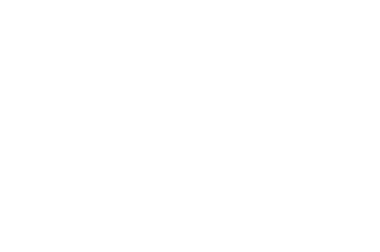

In [20]:
lyap_e_legit=np.zeros((10,4))
for i in range(10):
    lyap_e_legit[i,:]=lyap_e(X_test[idxs[i],:,:,0].flatten())
    plt.axis('off')
    
lyap_e_adv=np.zeros((100,4))
for i in tqdm(range(100)):
    lyap_e_adv[i,:]=lyap_e(adv[i,:,:,0].flatten())
    

# Unsupervised detection: Clustering
## The PCA visualization of the lyapunov exponent features:

/Users/nishant/Projects/unifyid/Lyapunov_defense/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


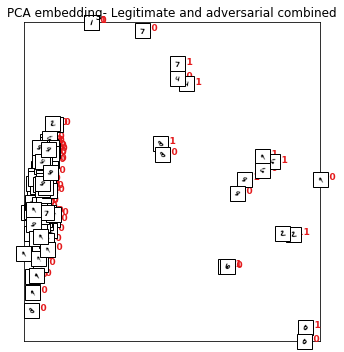

In [21]:
from sklearn import decomposition
X_lyap=np.vstack([lyap_e_legit,lyap_e_adv])
image_lyap=np.vstack([X_test[idxs,:,:,0],adv[:,:,:,0]])
y_lyap=np.zeros(110)
y_lyap[0:10]=1.1# Add the .1 just to make the label standout in the image below 


X_pca = decomposition.PCA(n_components=2).fit_transform(X_lyap)
plot_embedding_2(X_pca,y_lyap,image_lyap,
               "PCA embedding- Legitimate and adversarial combined")
plt.savefig('figs/pca_mnist.eps')
plt.tight_layout()
plt.show()


In [22]:
y_train=np.argmax(Y_train,axis=1)
#########
n_train=20
begin_ind=np.max(idxs)+1 # Just to ensure there is no overlap
X_lyap_train=np.zeros((10*n_train,4))
X_lyap_test_pos=np.zeros((10*n_train,4))
for digit in tqdm(range(10)):
    index_digit=np.where(y_train[0:1000]==digit)[0]
    ind_digit=index_digit[index_digit>begin_ind][0:n_train]
    for i,ind in enumerate(ind_digit):
        X_lyap_train[n_train*digit+i,:]=lyap_e(X_train[ind,:,:,0].flatten())
        X_lyap_test_pos[n_train*digit+i,:]=lyap_e(X_test[ind,:,:,0].flatten())

100%|██████████| 10/10 [04:00<00:00, 24.08s/it]


In [23]:
X_lyap_test_neg=lyap_e_adv.copy()
X_lyap_test=np.vstack([X_lyap_test_pos,X_lyap_test_neg])

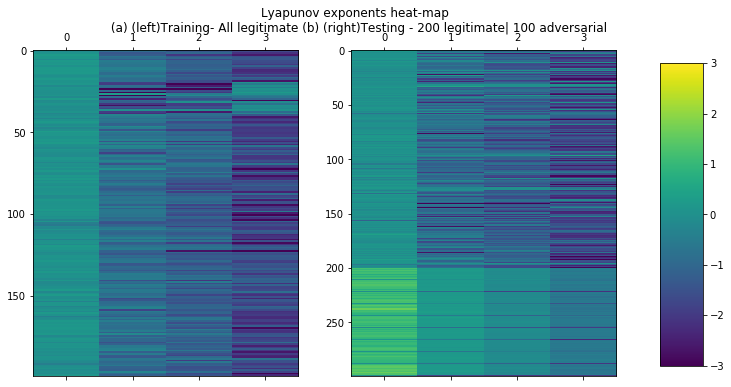

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
ax=axes.flat[0]

im = ax.matshow(X_lyap_train, vmin=-3, vmax=3,aspect='auto')

ax=axes.flat[1]
im = ax.matshow(X_lyap_test, vmin=-3, vmax=3,aspect='auto')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.suptitle('Lyapunov exponents heat-map \n (a) (left)Training- All legitimate (b) (right)Testing - 200 legitimate| 100 adversarial')
plt.savefig('figs/feat_heatmap_mnist.eps')
plt.show()

# Supervised classification (with only positive examples)
## Using the Iso-forest outlier detector.

In [25]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(random_state=8)
clf.fit(X_lyap_train[:,0:2])
adv_detect=clf.predict(X_lyap_test[:,0:2])
y_true=np.ones(300)
y_true[200:]=-1
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,adv_detect)

array([[ 90,  10],
       [ 29, 171]])

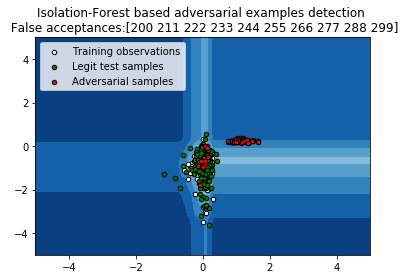

In [26]:
y_pred_train = clf.predict(X_lyap_train[:,0:2])
y_pred_test = clf.predict(X_lyap_test_pos[:,0:2])
y_pred_outliers = clf.predict(X_lyap_test_neg[:,0:2])

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

det_inlier_ind=np.where(adv_detect==1)
false_det_indices=det_inlier_ind[0][det_inlier_ind[0]>199]


plt.title('Isolation-Forest based adversarial examples detection \n False acceptances:'+str(false_det_indices))
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_lyap_train[:,0:2][:, 0], X_lyap_train[:,0:2][:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_lyap_test_pos[:,0:2][:, 0], X_lyap_test_pos[:,0:2][:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_lyap_test_neg[:,0:2][:, 0], X_lyap_test_neg[:,0:2][:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["Training observations",
            "Legit test samples", "Adversarial samples"],
           loc="upper left")
plt.savefig('figs/isoforest_mnist.eps')
plt.show()

# Visualizing what the flattened pseudo-time series looks like?

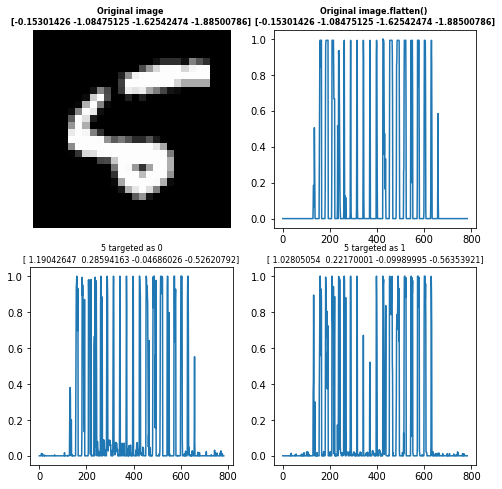

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(X_test[idxs[5],:,:,0],cmap='gray');
plt.axis('off');
plt.title('Original image \n'+str(lyap_e(X_test[idxs[5],:,:,0].flatten())),fontweight='bold',fontsize=8)

plt.subplot(2,2,2)
plt.plot(X_test[idxs[5],:,:,0].flatten())
plt.title('Original image.flatten() \n'+str(lyap_e(X_test[idxs[5],:,:,0].flatten())),fontweight='bold',fontsize=8)

plt.subplot(2,2,3)
i=0
plt.plot(grid_viz_data[5,i,:,:,0].flatten())
plt.title('5 targeted as '+str(i)+'\n'+str(lyap_e(grid_viz_data[5,i,:,:,0].flatten())),fontsize=8)

plt.subplot(2,2,4)
i=1
plt.plot(grid_viz_data[5,i,:,:,0].flatten())
plt.title('5 targeted as '+str(i)+'\n'+str(lyap_e(grid_viz_data[5,i,:,:,0].flatten())),fontsize=8)
plt.savefig('figs/ex_5_ts_mnist.eps')

# Robustness to synthetic noise:

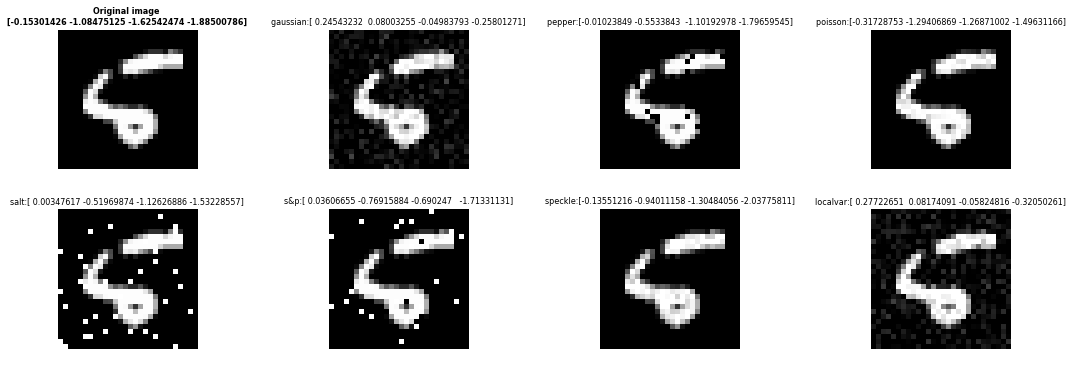

In [28]:
from skimage.util import random_noise
x_5=X_test[idxs[5],:,:,0]
X_5_noisy=np.zeros((8,28,28,1))
Lyapmat_5_noisy=np.zeros((8,4))
X_5_noisy[0,:,:,0]=x_5

plt.figure(figsize=(15,5))

lyap_5=lyap_e(X_test[idxs[5],:,:,0].flatten())
Lyapmat_5_noisy[0,:]=lyap_5
plt.subplot(2,4,1)
plt.imshow(x_5,cmap='gray')
plt.axis('off');
plt.title('Original image \n'+str(lyap_5),fontweight='bold',fontsize=8)

noise_modes=['gaussian','pepper','poisson','salt','s&p','speckle','localvar']
for i,noise_mode in enumerate(noise_modes):
    
    x_5_noisy=random_noise(x_5, mode=noise_mode, seed=None, clip=True)
    lyap_5_noisy=lyap_e(x_5_noisy.flatten())
    X_5_noisy[i+1,:,:,0]=x_5_noisy
    Lyapmat_5_noisy[i+1,:]=lyap_5_noisy
    plt.subplot(2,4,i+2)
    plt.imshow(x_5_noisy,cmap='gray')
    plt.axis('off');
    plt.title(noise_mode+':'+str(lyap_5_noisy),fontsize=8)
plt.tight_layout(pad=0.04, w_pad=0.05, h_pad=1.0)
plt.savefig('figs/ex_5_ts_noise.eps')

# Is the CNN actually robust to all these flavors of noise addition?

In [29]:
label_5_mat=np.zeros((8, 10))
label_5_mat[:,5]=1

eval_params = {'batch_size': np.minimum(nb_classes, source_samples)}
accuracy_noisy = model_eval(sess, x, y, preds, X_5_noisy, label_5_mat, args=eval_params)
accuracy_noisy

1.0

.. why yes it is!

    Now, let's recompute the efficay of the IsoForest classifier:

In [30]:
#########
n_train=20
begin_ind=np.max(idxs)+1 # Just to ensure there is no overlap
X_lyap_test_pos_noisy=np.zeros((10*n_train,4))
for digit in tqdm(range(10)):
    index_digit=np.where(y_train[0:1000]==digit)[0]
    ind_digit=index_digit[index_digit>begin_ind][0:n_train]
    for i,ind in enumerate(ind_digit):
        x_ind_noisy=random_noise(X_test[ind,:,:,0], mode='localvar', seed=None, clip=True)
        X_lyap_test_pos_noisy[n_train*digit+i,:]=lyap_e(x_ind_noisy.flatten())
        X_lyap_test_pos[n_train*digit+i,:]=lyap_e(X_test[ind,:,:,0].flatten())

100%|██████████| 10/10 [03:12<00:00, 19.25s/it]


In [31]:
print((clf.predict(X_lyap_test_pos_noisy[:,0:2])==-1).sum())
(clf.predict(X_lyap_test_pos[:,0:2])==1).sum()

200


171

Ouch!

How about augmentation?

In [32]:
clf=IsolationForest(random_state=8)
clf.fit(X_lyap_train[:,0:2])
adv_detect=clf.predict(X_lyap_test[:,0:2])
y_true=np.ones(300)
y_true[200:]=-1
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,adv_detect)

array([[ 90,  10],
       [ 29, 171]])

In [33]:
ind_train_noisy=np.random.choice(200,100,replace=False)
ind_test_noisy=np.setdiff1d(np.arange(200),ind_train_noisy)
X_augment_train=X_lyap_test_pos_noisy[ind_train_noisy,0:2]
X_augment_test=X_lyap_test_pos_noisy[ind_test_noisy,0:2]

X_lyap_train_aug=np.vstack([X_lyap_train[:,0:2],X_augment_train])
X_lyap_test_aug=np.vstack([X_augment_test,X_lyap_test[:,0:2]])
X_lyap_test_aug.shape

(400, 2)

In [34]:
clf=IsolationForest(random_state=8)
clf.fit(X_lyap_train_aug[:,0:2])
adv_detect=clf.predict(X_lyap_test_aug[:,0:2])
y_true=np.ones(400)
y_true[300:]=-1
from sklearn.metrics import confusion_matrix
Conf_mat=confusion_matrix(y_true,adv_detect)
Conf_mat

array([[ 91,   9],
       [ 49, 251]])

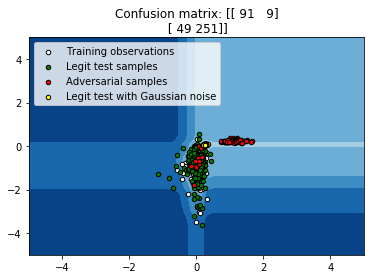

In [35]:
# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

det_inlier_ind=np.where(adv_detect==1)
false_det_indices=det_inlier_ind[0][det_inlier_ind[0]>200]


plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_lyap_train[:,0:2][:, 0], X_lyap_train[:,0:2][:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_lyap_test_pos[:,0:2][:, 0], X_lyap_test_pos[:,0:2][:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_lyap_test_neg[:,0:2][:, 0], X_lyap_test_neg[:,0:2][:, 1], c='red',
                s=20, edgecolor='k')

d = plt.scatter(X_augment_test[:,0:2][:, 0],X_augment_test[:,0:2][:, 1], c='yellow',
                s=20, edgecolor='k')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c,d],
           ["Training observations",
            "Legit test samples", "Adversarial samples", "Legit test with Gaussian noise"],
           loc="upper left")
plt.title('Confusion matrix: '+str(Conf_mat))
plt.savefig('figs/isoforest_mnist_g.eps')
plt.show()

# Is the noise too small?

One interesting fact to note is that all of the adversarial images that are "incorrectly" classified as not adversarial are the ones where the attack was targeted to the same class as the original image. Another important fact to note is that these also correspond to images that have a very small matrix norm between the original and adversarial images. Is it possible that the isolation forest is actually picking up on images that have noise larger than a certain magnitude and that the Gaussian noise in the above tests is too small?

## Comparing the magnitudes of the Gaussian noise and the adversarial perturbations

100%|██████████| 10/10 [00:00<00:00, 241.85it/s]


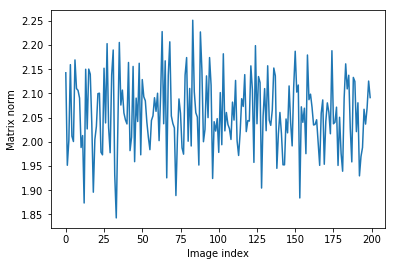

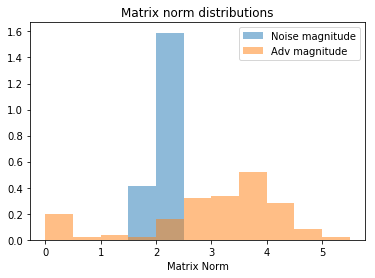

In [57]:
gaussian_dev=np.zeros(200)

n_train=20
begin_ind=np.max(idxs)+1 # Just to ensure there is no overlap
X_lyap_test_pos_noisy=np.zeros((10*n_train,4))
for digit in tqdm(range(10)):
    index_digit=np.where(y_train[0:1000]==digit)[0]
    ind_digit=index_digit[index_digit>begin_ind][0:n_train]
    for i,ind in enumerate(ind_digit):
        x_ind_noisy=random_noise(X_test[ind,:,:,0], mode='localvar', seed=None, clip=True)
        gaussian_dev[n_train*digit+i]=np.linalg.norm(np.abs(X_test[ind,:,:,0]-x_ind_noisy))

plt.plot(gaussian_dev)
plt.xlabel('Image index')
plt.ylabel('Matrix norm')

plt.figure()
plt.xlabel('Matrix Norm')
plt.title('Matrix norm distributions')
plt.hist(gaussian_dev, bins=np.arange(0, 6, 0.5), normed=True, alpha=0.5, label='Noise magnitude')
plt.hist(dev, bins=np.arange(0, 6, 0.5), normed=True, alpha=0.5, label='Adv magnitude')
plt.legend()
plt.savefig('figs/noise_magnitude_hist.eps')
plt.show()

It seems the magnitude of the Gaussian noise tends to be smaller than the magnitude of the adversarial perturbations. Let's make the test more comparable by sampling the magnitude of the noise vector from the distribution of adversarial perturbation magnitudes.

In [59]:
#Redoing the noisy data generation with larger magnitudes
gaussian_dev = np.zeros(200)

n_train = 20
begin_ind = np.max(idxs)+1 # Just to ensure there is no overlap
X_lyap_test_pos_noisy_mag = np.zeros((10*n_train,4))
for digit in tqdm(range(10)):
    index_digit = np.where(y_train[0:1000]==digit)[0]
    ind_digit = index_digit[index_digit>begin_ind][0:n_train]
    for i,ind in enumerate(ind_digit):
        random_noise_vector = random_noise(np.zeros_like(X_test[ind,:,:,0]), mode='localvar', seed=None, clip=True)
        random_noise_vector /= np.linalg.norm(random_noise_vector)
        random_noise_vector *= np.random.choice(dev)
        x_ind_noisy = X_test[ind,:,:,0] + random_noise_vector
        X_lyap_test_pos_noisy_mag[n_train*digit+i,:] = lyap_e(x_ind_noisy.flatten())
        X_lyap_test_pos[n_train*digit+i,:] = lyap_e(X_test[ind,:,:,0].flatten())
        gaussian_dev[n_train*digit+i]=np.linalg.norm(np.abs(X_test[ind,:,:,0]-x_ind_noisy))


100%|██████████| 10/10 [02:56<00:00, 17.70s/it]


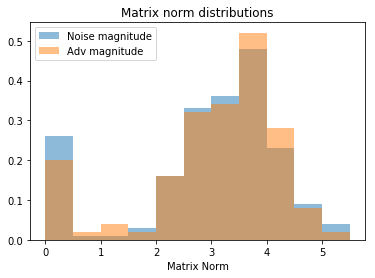

In [60]:
plt.figure()
plt.xlabel('Matrix Norm')
plt.title('Matrix norm distributions')
plt.hist(gaussian_dev, bins=np.arange(0, 6, 0.5), normed=True, alpha=0.5, label="Noise magnitude")
plt.hist(dev, bins=np.arange(0, 6, 0.5), normed=True, alpha=0.5, label="Adv magnitude")
plt.legend()
plt.savefig('figs/adj_noise_magnitude_hist.eps')
plt.show()

In [39]:
ind_train_noisy_mag = np.random.choice(200, 100, replace=False)
ind_test_noisy_mag = np.setdiff1d(np.arange(200), ind_train_noisy)
X_augment_train_mag = X_lyap_test_pos_noisy_mag[ind_train_noisy_mag,0:2]
X_augment_test_mag = X_lyap_test_pos_noisy_mag[ind_test_noisy_mag,0:2]

X_lyap_train_aug_mag = np.vstack([X_lyap_train[:,0:2], X_augment_train_mag])
X_lyap_test_aug_mag = np.vstack([X_augment_test_mag, X_lyap_test[:,0:2]])
X_lyap_test_aug_mag.shape

(400, 2)

In [40]:
clf=IsolationForest(random_state=8)
clf.fit(X_lyap_train_aug_mag[:,0:2])
adv_detect=clf.predict(X_lyap_test_aug_mag[:,0:2])
y_true=np.ones(400)
y_true[300:]=-1
from sklearn.metrics import confusion_matrix
Conf_mat=confusion_matrix(y_true,adv_detect)
Conf_mat

array([[ 90,  10],
       [ 34, 266]])

Initially, we posit that the Lyaponuv method is able to detect adversarially modified images. However, it is not clear, a priori, whether the method is truly detecting adversarial images or merely picking up on an increased amount of noise present in the image. To test this, we run our classifier on images with random noise added to them. We initially find that the isolation random forest considers these images to be outliers with respect to the set of natural MNIST images. However, upon retraining the isolation forest with noisy examples included, we find that it is able to differentiate betwen adversarial and nonadversarial images with accuracy comparable to the original model. 

There remains, however, one additional possibility that the experiment presented above eliminates. We note that on the original isolation forest, with an inlier set defined only by natural images, the "false negatives" are all test inputs that have very small magnitude perturbations. A natural question follows from this observation: does the Lyaponuv feature space treat all large-magnitude perturbations equally? To test this question, we construct a new dataset augmented with noisy images. However, this time we select the distribution of noise magnitudes to match the distribution of magnitudes of our adversarial perturbations. We find no loss in accuracy using this larger magnitude random noise. This leads us to conclude that the Lyaponuv feature space is truly able to differentiate between adversarial perturbations and random noise, even at comparable perturbation magnitudes.

# Testing Other Attacks

In [41]:
targeted_attacks = {
    'JSMA' : SaliencyMapMethod(model, back='tf', sess=sess),
    'FGSM' : FastGradientMethod(model, back='tf', sess=sess),
    'MadryEtAl' : MadryEtAl(model, back='tf', sess=sess)
}
#There is no targeted version of the DeepFool attack.

untargeted_attacks = {
    'JSMA' : SaliencyMapMethod(model, back='tf', sess=sess),
    'FGSM' : FastGradientMethod(model, back='tf', sess=sess),
    'DeepFool' : DeepFool(model, back='tf', sess=sess),
    'MadryEtAl' : MadryEtAl(model, back='tf', sess=sess)
}

#We have to create two versions of each attack because if we call generate_np with y_target and then attempt to call
#it again without a target, the attack objects raise an error.

set_log_level(logging.WARNING)

### 1. Generate Targeted Adversarial Data

We will use default CleverHand parameters for all attacks when available. If not available, we will use the parameters used in the original paper.

In [42]:
def lyap_e_batch(imgs):
    lyap_e_adv=np.zeros((imgs.shape[0],4))
    for i in tqdm(range(imgs.shape[0])):
        lyap_e_adv[i,:]=lyap_e(imgs[i,:,:,0].flatten())
    return lyap_e_adv

In [43]:
targeted_lyap_e = {}

#JSMA
targeted_lyap_e['JSMA'] = lyap_e_batch(targeted_attacks['JSMA'].generate_np(adv_inputs, **{'y_target' : adv_ys}))

#FGSM
targeted_lyap_e['FGSM'] = lyap_e_batch(targeted_attacks['FGSM'].generate_np(adv_inputs, **{'y_target' : adv_ys}))

#MadryEtAl
madry_params = {'y_target' : adv_ys, 'eps_iter' : 0.3}
targeted_lyap_e['MadryEtAl'] = lyap_e_batch(targeted_attacks['MadryEtAl'].generate_np(adv_inputs, **madry_params))


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


### 2. Generate Untargeted Adversarial Data

In [44]:
untargeted_lyap_e = {}

#JSMA
untargeted_lyap_e['JSMA'] = lyap_e_batch(untargeted_attacks['JSMA'].generate_np(adv_inputs))

#FGSM
untargeted_lyap_e['FGSM'] = lyap_e_batch(untargeted_attacks['FGSM'].generate_np(adv_inputs))

#DeepFool
untargeted_lyap_e['DeepFool'] = lyap_e_batch(untargeted_attacks['DeepFool'].generate_np(adv_inputs))

#MadryEtAl
untargeted_lyap_e['MadryEtAl'] = lyap_e_batch(untargeted_attacks['MadryEtAl'].generate_np(adv_inputs, **{'eps_iter' : 0.3}))

#CarliniWagnerL2
targeted = False
cw_params = get_cw_params()
untargeted_lyap_e['CW'] = lyap_e_batch(cw.generate_np(adv_inputs, **cw_params))

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


In [45]:
all_data = {}

for name, data in targeted_lyap_e.items():
    all_data[name + ' targeted'] = data

for name, data in untargeted_lyap_e.items():
    all_data[name + ' untargeted'] = data

### 3. Rebuild the original Isolation Forest Classifier

In [46]:
clf=IsolationForest(random_state=8)
clf.fit(X_lyap_train[:,0:2])

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=8,
        verbose=0)

### 4. Check True Positive and False Negative Rates

In [47]:
for name, data in all_data.items():
    adv_detect=clf.predict(data[:,0:2])
    true_negative_rate = np.mean(adv_detect==-1)
    print('{0} true negative rate: {1}'.format(name, true_negative_rate))

JSMA targeted true negative rate: 0.03
FGSM targeted true negative rate: 0.0
MadryEtAl targeted true negative rate: 0.0
JSMA untargeted true negative rate: 0.03
FGSM untargeted true negative rate: 0.0
DeepFool untargeted true negative rate: 1.0
MadryEtAl untargeted true negative rate: 0.0
CW untargeted true negative rate: 1.0


### Retry using all 4 Lyapunov exponent dimensions

In [48]:
clf=IsolationForest(random_state=8)
clf.fit(X_lyap_train[:,0:4])

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=8,
        verbose=0)

In [49]:
for name, data in all_data.items():
    adv_detect=clf.predict(data[:,0:4])
    true_negative_rate = np.mean(adv_detect==-1)
    print('{0} true negative rate: {1}'.format(name, true_negative_rate))

JSMA targeted true negative rate: 0.04
FGSM targeted true negative rate: 0.62
MadryEtAl targeted true negative rate: 1.0
JSMA untargeted true negative rate: 0.04
FGSM untargeted true negative rate: 0.8
DeepFool untargeted true negative rate: 1.0
MadryEtAl untargeted true negative rate: 1.0
CW untargeted true negative rate: 1.0
